# Analyzing Emergence of New Phase

In [23]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python
from scipy.optimize import leastsq #for least-squares fitting
from scipy.signal import blackmanharris as bh #for potentially filtering raw images

%matplotlib inline
import mpld3 #For making nice looking plots
from mpld3 import plugins
mpld3.enable_notebook()
import matplotlib #for plotting and displaying images
from matplotlib import pylab

#For making interactive user interfaces (buttons and sliders and such)
import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

#Loading the particle tracking software
import sys
sys.path.append("Z:\\Code\\BeadTracking\\track") #Locate code
import tiff_file #Ignore any warnings importing this may cause

sys.path.append("Z:\Code\ddm")
import ddm_clean as ddm

In [2]:
data_dir = "Z:\\2017-08-18_0818rm02_pnipam-xan\\after_reheating\\"
file_name = "10x_4fps005_2x2bin.tif" #1512 frames

Let's take a look at a couple frames of this movie.

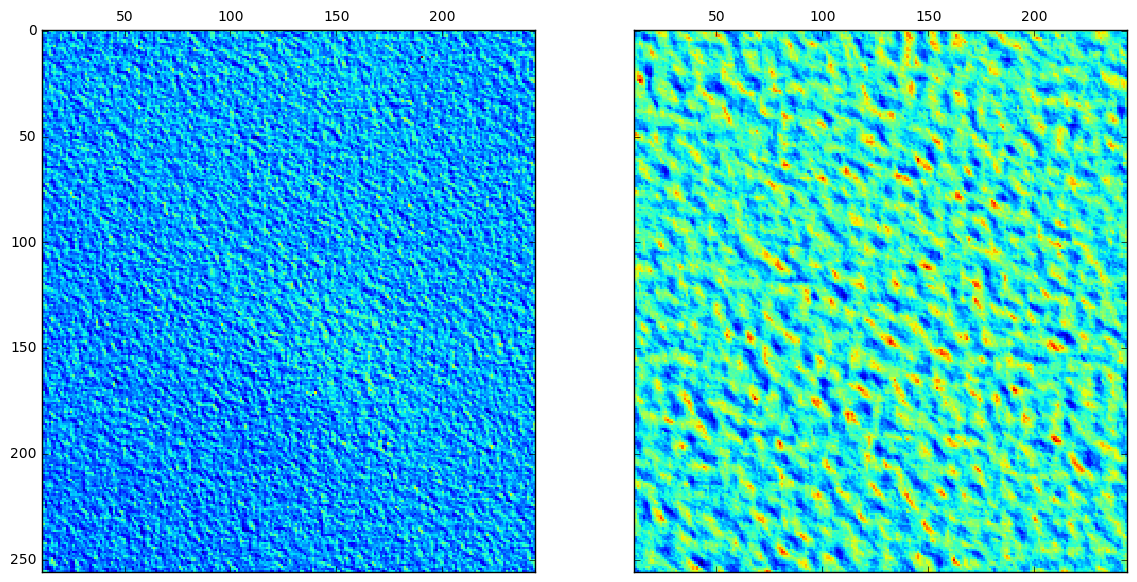

In [7]:
image_0100 = tiff_file.imread(data_dir+file_name, key=100) #100th image in file
image_0600 = tiff_file.imread(data_dir+file_name, key=600) #600th image
fig,ax = plt.subplots(1,2,sharey=True,figsize=(14,7)) #making side-by-side plot (#rows = 1, #columns=2)
ax[0].matshow(image_0100) #On first subplot show frame 100
ax[1].matshow(image_0600) #On second subplot show frame 600

Is there a characteristic feature size in these images? What would you say it is?

In [25]:
#We'll use the Fourier transform to find that characteristic size
fft_im_0100 = abs(fftshift(fft2(image_0100-image_0100.mean())))**2
radial_av_fftim100 = ddm.newRadav(fft_im_0100/(image_0100.shape[0]*image_0100.shape[1]))
fft_im_0600 = abs(fftshift(fft2(image_0600-image_0600.mean())))**2
radial_av_fftim600 = ddm.newRadav(fft_im_0600/(image_0600.shape[0]*image_0600.shape[1]))
pixel_scale = 1.0 #Microns per pixel. But for now we'll be in units of pixels
f = np.arange(1,256/2)*(1./(256*pixel_scale)) 

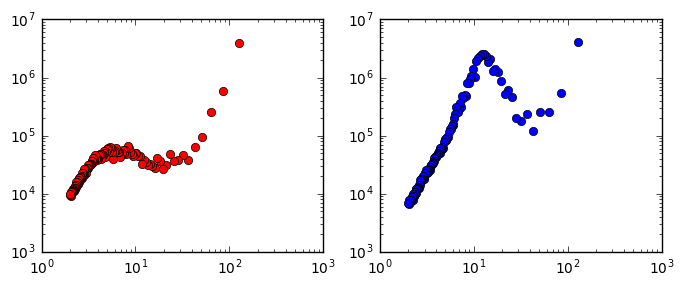

In [26]:
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].loglog(1./f,radial_av_fftim100,'ro')
ax[1].loglog(1./f,radial_av_fftim600,'bo')
plugins.connect(fig, plugins.MousePosition(fontsize=14))

It seems that the FT has a peak at a frequency corresponding to about 7 pixels for image 100 and 13 pixels for image 600. 

Let's visually check that. We'll plot the images and overlay a grid with a spacing of that characteristic size.

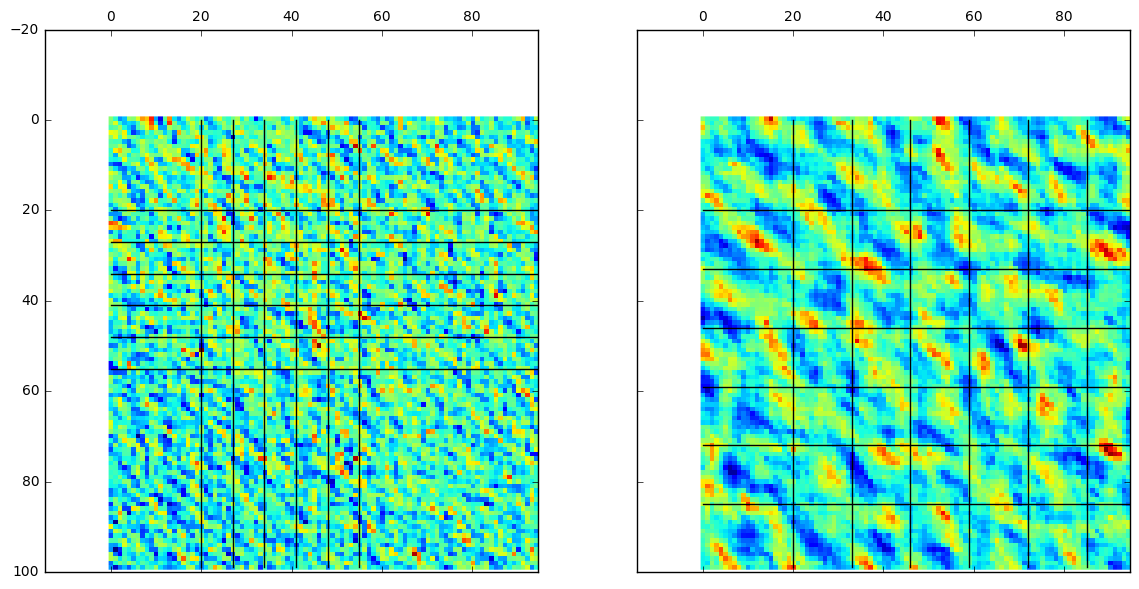

In [35]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(14,7))

#Crop the images and display
ax[0].matshow(image_0100[120:220,120:220]) #Just showing a 100x100 pixel region of the image
ax[1].matshow(image_0600[120:220,120:220])

#From above plot, it seems that characteristic sizes are 7 and 13 pixels, respectively
characteristic_size = [7,13]

for i,axis in enumerate(ax):
    spacing = characteristic_size[i]
    axis.plot(range(100),np.ones((100))*20,'-k'); axis.plot(range(100),np.ones((100))*(20+spacing),'-k');
    axis.plot(range(100),np.ones((100))*(20+2*spacing),'-k'); axis.plot(range(100),np.ones((100))*(20+3*spacing),'-k');
    axis.plot(range(100),np.ones((100))*(20+4*spacing),'-k'); axis.plot(range(100),np.ones((100))*(20+5*spacing),'-k');
    axis.plot(np.ones((100))*20,range(100),'-k'); axis.plot(np.ones((100))*(20+spacing),range(100),'-k');
    axis.plot(np.ones((100))*(20+2*spacing),range(100),'-k'); axis.plot(np.ones((100))*(20+3*spacing),range(100),'-k');
    axis.plot(np.ones((100))*(20+4*spacing),range(100),'-k'); axis.plot(np.ones((100))*(20+5*spacing),range(100),'-k');

In [147]:
#Initialize empty lists to store things in
radial_averages = []
frames = []

pixel_scale = 1.0 #Microns per pixel. But for now we'll be in units of pixels
f = np.arange(1,256/2)*(1./(256*pixel_scale)) 

#this for loop will go from 0 to 1200 in steps of 5 [ie, 0,5,10...]
for i in range(5,1200,10): 
    image = tiff_file.imread(data_dir+file_name, key=range(i-5,i+5)).mean(axis=0) #read image i in file
    nx, ny = image.shape #get the dimensions of this image
    fft_im = abs(fftshift(fft2(image-image.mean()))**2)
    radial_av_fftim = ddm.newRadav(fft_im/(nx*ny))
    radial_averages.append(radial_av_fftim)
    frames.append(i)
    

    
#tiff_file.imsave("seq_ffts.tif", np.array(sequence_of_ffts))
#tiff_file.imsave("seq_ffts_logscale.tif", np.array(sequence_of_ffts_log))

rad_av = np.array(radial_averages)
np.save("radial_averages_of_fft.npy", rad_av)

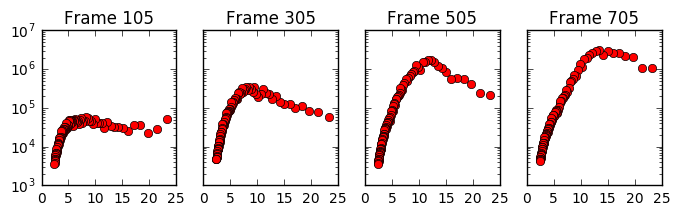

In [152]:
fig,axes = plt.subplots(1,4,sharey=True,figsize=(8,2))
for i,ax in enumerate(axes):
    #Plot frequencies from 10th to -20th (20th from the end)
    ax.semilogy(1./f[10:-20],rad_av[(i*20)+10,10:-20],'ro')
    ax.set_title("Frame %i" % frames[(i*20)+10])
plugins.connect(fig, plugins.MousePosition(fontsize=14))

Let's find the location of the peak of this functions to determine the characteristic size.

In [153]:
#Make a peaked function (we'll use a Gaussian)
def peakedGauss(params, x):
    '''
    Returns a 1D Gaussian
    '''
    B = params[0] #Noise
    A = params[1] #amplitude
    mu = params[2] #center
    width = params[3]
    expTerm = ((x-mu)/width)**2
    g = B + (A * np.exp(-1*expTerm))
    return g

def errorFunc(params, data, x):
    '''
    Error function for least squares fitting
    '''
    return data-peakedGauss(params,x)

In [157]:
#Let's consider frame 505 since that one looks nice from the plot above
w = np.where(np.array(frames)==505)
radial_av_fft_frameX = rad_av[w[0][0],:]

#Now, where is that peaked. We'll use np.argmax which returns the argument (ie, index) of the maximum of the array
w_peak = np.argmax(radial_av_fft_frameX[10:-10]) + 10 #Doing the [10:-10] thing to get rid of noisy high/low freq data
print "Peak at %i which corresponds to characteristic size of %.2f pixels" % (w_peak, 1.0/f[w_peak])

Peak at 20 which corresponds to characteristic size of 12.19 pixels


Let's examine a little chunk of the radially averaged FT centered around the peak. 
Then we can fit that to a peaked function to more accurately determine the characteristic size.

In [158]:
width_of_fit_region = 10
frequencies = f[w_peak - width_of_fit_region:w_peak + width_of_fit_region]
radial_av_fft_frameX_chunk = radial_av_fft_frameX[w_peak - width_of_fit_region:w_peak + width_of_fit_region]

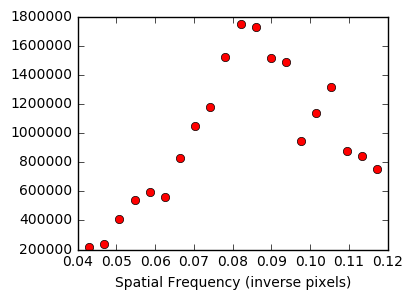

In [159]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(frequencies, radial_av_fft_frameX_chunk, 'ro')
ax.set_xlabel("Spatial Frequency (inverse pixels)")

From fit, found characteristic size of 11.37 pixels


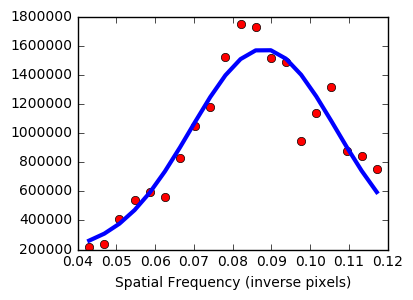

In [160]:
#First, establish initial guess parameters for fitting function plotted above to Gaussian
guessNoise = radial_av_fft_frameX_chunk.min()
guessAmplitude = radial_av_fft_frameX_chunk.max() - guessNoise
guessCenter = frequencies[width_of_fit_region]
guessWidth = guessCenter - frequencies[0]
initGuess = np.array([guessNoise, guessAmplitude, guessCenter, guessWidth])

#Now, do the fit
fit,flag = leastsq(errorFunc, initGuess, args=(radial_av_fft_frameX_chunk, frequencies))

#Plot result
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(frequencies, radial_av_fft_frameX_chunk, 'ro')
ax.plot(frequencies, peakedGauss(fit,frequencies), '-b',lw=3)
ax.set_xlabel("Spatial Frequency (inverse pixels)")
print "From fit, found characteristic size of %.2f pixels" % (1./fit[2])

Now we just have to do this for *all* frames (or at least all the frames we calculated the FT).

Before we do that. Let's just make some quick little helper functions. 

In [161]:
def returnChunk(radialAvgFT, frequencies, chunk_width=10):
    w_peak = np.argmax(radialAvgFT[10:-10])+10
    #print w_peak
    return radialAvgFT[w_peak-chunk_width:w_peak+chunk_width], frequencies[w_peak-chunk_width:w_peak+chunk_width]

def returnBestGuessParams(littleChunk, frequencies):
    guessNoise = littleChunk.min()
    guessAmplitude = littleChunk.max()-guessNoise
    guessCenter = frequencies[int(len(frequencies)/2.0)]
    guessWidth = guessCenter - frequencies[0]
    return np.array([guessNoise, guessAmplitude, guessCenter, guessWidth])

In [194]:
charSize = []
framesUsed = []
for i,radialAvgs in enumerate(rad_av):
    #skip first 12 because hard to detect distinct domains in early times
    if i>5:
        chunkRadAv, chunkFreq = returnChunk(radialAvgs, f)
        initGuess = returnBestGuessParams(chunkRadAv, chunkFreq)
        fit,flag = leastsq(errorFunc, initGuess, args=(chunkRadAv,chunkFreq))
        charSize.append(1./fit[2])
        framesUsed.append(frames[i])
charSize = np.array(charSize)
framesUsed = np.array(framesUsed)

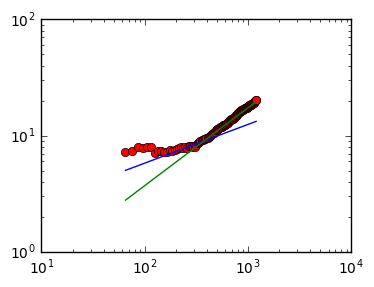

In [195]:
#Check for power law dynamics of growth of the characteristic size of domains
fig,ax = plt.subplots(figsize=(4,3))
ax.loglog(framesUsed, charSize,'ro')
ax.loglog(framesUsed, 1.25*(framesUsed**(1./3)),'-b')
ax.loglog(framesUsed, 0.17*(framesUsed**(0.67)),'-g')
plugins.connect(fig, plugins.MousePosition(fontsize=14))

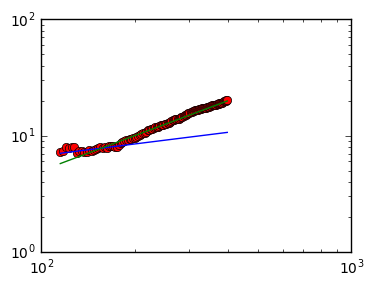

In [196]:
#Check for power law dynamics of growth of the characteristic size of domains
fig,ax = plt.subplots(figsize=(4,3))
newTime = 100+(framesUsed-frames[0])/4.0 #Recorded at 4fps
ax.loglog(newTime, charSize,'ro')
ax.loglog(newTime, 1.45*(newTime**(1./3)),'-b')
ax.loglog(newTime, 0.05*(newTime**(1)),'-g')
plugins.connect(fig, plugins.MousePosition(fontsize=14))

In [174]:
frames[0]

5

In [179]:
framesUsed

array([ 135,  145,  155,  165,  175,  185,  195,  205,  215,  225,  235,
        245,  255,  265,  275,  285,  295,  305,  315,  325,  335,  345,
        355,  365,  375,  385,  395,  405,  415,  425,  435,  445,  455,
        465,  475,  485,  495,  505,  515,  525,  535,  545,  555,  565,
        575,  585,  595,  605,  615,  625,  635,  645,  655,  665,  675,
        685,  695,  705,  715,  725,  735,  745,  755,  765,  775,  785,
        795,  805,  815,  825,  835,  845,  855,  865,  875,  885,  895,
        905,  915,  925,  935,  945,  955,  965,  975,  985,  995, 1005,
       1015, 1025, 1035, 1045, 1055, 1065, 1075, 1085, 1095, 1105, 1115,
       1125, 1135, 1145, 1155, 1165, 1175, 1185, 1195])